# 深度学习 实验6

本节课我们使用主成分分析法进行降维，PCA 算法是机器学习中常用的特征降维方法，可以将高维数据映射到低维空间中，且能保证最大可分性与最近重构性。

## Task 1

再次使用手写数字识别数据集，将数据降维后，观察并分析数据的分布。

## Task 2

将数据集降维到不同维度后，任选一个分类器模型，分析降维后的维度对训练效率与准确率的影响。

由于 PCA 算法需要求解矩阵特征值与特征向量，因此本实验不要求从底层原理实现 PCA，可以考虑参考调用 sklearn 库：  
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA

读取数据

In [2]:
# Import standard packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
from random import *

# Import additional packages
from itertools import combinations
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA  # 进行主成分分析


alpha = 0.05
p = 784
n = 42000

x = pd.read_csv('train.csv')
data = x.values * 1.0
df = pd.DataFrame(data)
#label 784个pixl
print(df.head())



# 对数据进行分割
X = data[:,1:p+1]
Y = data[:,0]#存储label

print(Y)

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   779  780  781  782  783  784  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 785 columns]
[1. 0. 1. ... 7. 6. 9.]


数据降维

In [3]:
d=500
pca = PCA(n_components=d)
pca.fit(X)
X_new = pca.transform(X)
print(X_new)

[[-6.61595780e+02 -6.99311328e+02  1.83282040e+02 ...  1.23684641e+00
  -6.49045035e-01 -1.20309097e+00]
 [ 1.70145168e+03 -3.60551556e+02 -5.01805594e+02 ...  8.74114423e-01
  -1.19495560e+00 -3.30138595e+00]
 [-8.86894434e+02 -2.93765782e+02  6.71553099e+01 ... -7.62133756e-02
  -9.04781050e-01 -2.76861573e-01]
 ...
 [ 3.36269982e+02  9.50015280e+02 -1.68605414e+02 ...  1.06255322e+00
  -6.22223452e+00  1.44096433e+00]
 [ 3.27399392e+02  6.20160894e+01  6.97536401e+02 ... -2.24100335e+00
  -4.18767371e+00 -4.12913537e+00]
 [-3.64249200e+02  4.18893026e+02  6.28998232e+01 ... -4.80743909e-01
  -2.86369883e+00  1.61356904e+00]]


选取潜亏神经网络进行训练，预测，计算准确度

定义神经网络

In [4]:
def get_y(data):
    # 将标签转化为 one-hot 向量
    y_list = []
    for i in data:
        y = [0] * 10
        y[int(i)] = 1
        y_list.append(y)
    return np.array(y_list)


# 计算准确率
def accuracy(y_pred, y_true):
    ac = 0
    for i in range(y_true.shape[1]):
        # 计算预测的标签
        temp = [y_pred[j][i] for j in range(10)]
        label_pred = temp.index(max(temp))
        # 计算真实的标签
        temp = [y_true[j][i] for j in range(10)]
        label_true = temp.index(max(temp))
        if label_pred == label_true:
            ac += 1
    return ac / y_true.shape[1]


# 神经网络的层（啥都不做的层）
class DenseLayer:
    def __init__(self, n):
        self.n = n

    def connect(self, layer):
        pass

    def forward(self, x):
        return x

    def backward(self, dy):
        return dy


# 神经网络的层（全连接层）
class LinearLayer:
    # 初始化
    def __init__(self, n, activation, activation_diff):
        # 神经元个数
        self.n = n
        # 激活函数
        self.activation = activation
        # 激活函数导数
        self.activation_diff = activation_diff
        # 学习率
        self.eta = 0.001

    # 全连接，随机初始化 w，一个self.nxlayer.n的矩阵
    def connect(self, layer):
        self.w = np.random.rand(self.n, layer.n + 1) * 0.2 - 0.1

    # 前向传播
    def forward(self, x):
        self.x = x
        self.u = np.matmul(self.w, self.x)  # u=w*x
        self.y = self.activation(self.u)  # y=sigmoid(wx)
        return self.y


    # 反向传播 传入损失函数对该层每个输出值的导数，传出损失函数对该层每个输入值的导数
    def backward(self, dy, update=True):
        self.du = dy * self.activation_diff(self.u)  # (y-sigmoid(wx+b))xsigmoid'(wx+b)--{10x128}*{10x128}={10*128}
        self.dw = np.matmul(self.du, self.x.T)  # {10x31}

        self.w_nb = np.delete(self.w, self.w.shape[1] - 1, axis=1)

        self.dx = np.matmul(self.w_nb.T, self.du)
        if update:
            self.w -= self.eta * self.dw  # {10x31}
        return self.dx


# sigmoid 激活函数 f(x)=1/(1+exp(-x))
def sigmoid(x):
    x_ravel = x.ravel()  # 将numpy数组展平
    length = len(x_ravel)
    y = []
    for index in range(length):
        if x_ravel[index] >= 0:
            y.append(1.0 / (1 + np.exp(-x_ravel[index])))
        else:
            y.append(np.exp(x_ravel[index]) / (np.exp(x_ravel[index]) + 1))
    return np.array(y).reshape(x.shape)


# sigmoid 激活函数的导数 f'(x)=f(x)(1-f(x))
def sigmoid_diff(x):
    return sigmoid(x) * (1 - sigmoid(x))


def softmax(x):
    x=x.T
    X=[]
    for r in x:
        e_x = np.exp(r - np.max(r))
        X.append(e_x / e_x.sum())
    X=np.array(X)
    return X.T
def softmax_diff(x):
    return 1;








开始训练并预测

以下是将数据将至500维之后的准确率训练轨迹

0.1171875
0.8671875
0.890625
0.8359375
0.9140625
0.8671875
0.9140625
0.8828125
0.90625
0.8671875
0.9375
0.921875
0.921875
0.8515625
0.953125
0.8984375
0.9375
0.90625
0.9140625
0.921875
0.875
0.8984375
0.8828125
0.9375
0.90625
0.9140625
0.9375
0.9453125
0.890625
0.875
0.953125
0.890625
0.9296875
0.90625
0.9296875
0.9375
0.875
0.9140625
0.890625
0.90625
0.90625
0.9140625
0.890625
0.9140625
0.9140625
0.9140625
0.9140625
0.921875
0.9296875
0.9453125
0.8984375
0.90625
0.921875
0.90625
0.8828125
0.875
0.9296875
0.921875
0.90625
0.875
0.9140625
0.9296875
0.921875
0.921875
0.953125
0.9296875
0.9140625
0.9140625
0.9375
0.9375
0.90625
0.90625
0.9375
0.9296875
0.9140625
0.9609375
0.9375
0.9140625
0.90625
0.9375
0.9375
0.9296875
0.90625
0.9375
0.8984375
0.9609375
0.8671875
0.953125
0.90625
0.921875
0.921875
0.953125
0.9296875
0.953125
0.90625
0.9453125
0.921875
0.9609375
0.9296875
0.921875


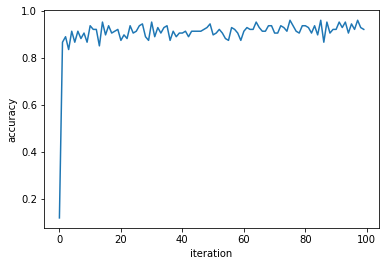

In [5]:
train_y = get_y(Y)
train_x=X_new
# 转置一下，每个样本数据以列向量进行存储和计算
train_x = train_x.T  # 784x42000
ones = [1 for _ in range(42000)]
train_x = np.vstack((train_x, ones))
train_y = train_y.T  # 变成列向量,10x42000

# 构造神经网络
input_layer = DenseLayer(d)
hidden_layer = LinearLayer(50, sigmoid, sigmoid_diff)
hidden_layer.connect(input_layer)
output_layer = LinearLayer(10, softmax, softmax_diff)
#output_layer = LinearLayer(10, sigmoid, sigmoid_diff)
output_layer.connect(hidden_layer)

ac = []
for iteration in range(10000):
    # 正向传播
    index = sample([i for i in range(42000)], 128)
    x = train_x[:, index]
    y1 = train_y[:, index]
    u = input_layer.forward(x)  # u={785x128}
    v = hidden_layer.forward(u)  # v={30x785}{785x128}={30x128}
    ones = [1 for _ in range(128)]
    v = np.vstack((v, ones))  # {31x128}

    # 使用softmax函数
    y = output_layer.forward(v)  # y={10x31}{31x128}={10x128}
    # 计算损失函数对每个输出值的导数
    #d_loss = (y - y1) / y.shape[1]
    d_loss = (y - y1)
    # 反向传播
    dv = output_layer.backward(d_loss)
    du = hidden_layer.backward(dv)
    # 输出准确率
    if iteration % 100 == 0:
        print(iteration/100,accuracy(y, y1))
        ac.append(accuracy(y, y1))

plt.plot([i for i in range(100)], ac)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

将数据降至不同维之后，观察平均准确率的变化

0.841859375
0.84146875
0.840875
0.8465625
0.83709375
0.843375
0.842703125
0.843359375
0.843078125
0.84253125
0.842875
0.841421875
0.846953125
0.843390625
0.83990625
0.841609375
0.844453125
0.839984375
0.839765625
0.83459375
0.848375
0.840171875
0.844296875
0.83959375
0.8395625
0.83878125
0.84296875
0.84125
0.842359375
0.83890625
0.838796875
0.840390625
0.83628125
0.84234375
0.841015625
0.841171875
0.8374375
0.844640625
0.83690625
0.8465625
0.843359375
0.845078125
0.8400625
0.840484375
0.841453125
0.842796875
0.841421875
0.8436875
0.840421875
0.84215625
0.83928125
0.8400625
0.840484375
0.839953125
0.842296875
0.84221875
0.8385
0.84128125
0.8414375
0.8356875
0.83778125
0.836328125
0.84209375
0.839484375
0.8415625
0.839421875
0.83971875
0.8383125
0.839828125
0.83853125
0.843578125
0.83828125
0.8435625
0.838546875
0.8383125
0.840546875
0.843890625
0.843375
0.83771875
0.84265625
0.83975
0.846953125
0.842828125
0.847390625
0.8375
0.83965625
0.84465625
0.843765625
0.836046875
0.8386875
0.8396

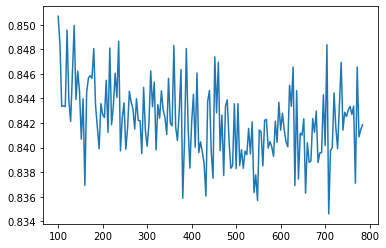

In [7]:
D=[i for i in range(784,99,-4)]
acs=[]
for d in D:
    train_y = get_y(Y)
    pca = PCA(n_components=d)
    pca.fit(X)
    X_new = pca.transform(X)
    train_x = X_new
    # 转置一下，每个样本数据以列向量进行存储和计算
    train_x = train_x.T  # 784x42000
    ones = [1 for _ in range(42000)]
    train_x = np.vstack((train_x, ones))
    train_y = train_y.T  # 变成列向量,10x42000

    # 构造神经网络
    input_layer = DenseLayer(d)
    hidden_layer = LinearLayer(50, sigmoid, sigmoid_diff)
    hidden_layer.connect(input_layer)
    output_layer = LinearLayer(10, softmax, softmax_diff)
    # output_layer = LinearLayer(10, sigmoid, sigmoid_diff)
    output_layer.connect(hidden_layer)

    ac = []
    for iteration in range(500):
        # 正向传播
        index = sample([i for i in range(42000)], 128)
        x = train_x[:, index]
        y1 = train_y[:, index]
        u = input_layer.forward(x)  # u={785x128}
        v = hidden_layer.forward(u)  # v={30x785}{785x128}={30x128}
        ones = [1 for _ in range(128)]
        v = np.vstack((v, ones))  # {31x128}

        # 使用softmax函数
        y = output_layer.forward(v)  # y={10x31}{31x128}={10x128}
        # 计算损失函数对每个输出值的导数
        # d_loss = (y - y1) / y.shape[1]
        d_loss = (y - y1)
        # 反向传播
        dv = output_layer.backward(d_loss)
        du = hidden_layer.backward(dv)
        # 输出准确率
        ac.append(accuracy(y, y1))
    ac=np.array(ac)
    acs.append(ac.mean())
    print(ac.mean())
plt.plot(D, acs)



In [8]:
plt.show()

可以发现随着维度从784到100逐渐降低，准确率一直稳定在0.83～0.84之间，并且有微弱的提升